# False Color Visualization of the 2025 Los Angeles Wildfires

**Author:** Emily Miller 

**Date:** November 20, 2025

**Repository:** https://github.com/rellimylime/eds220-hwk4

## About

### Purpose
This analysis creates false color visualizations of the January 2025 Eaton and Palisades fires in Los Angeles County using Landsat 8 satellite imagery. By combining near-infrared and shortwave infrared bands, the analysis highlights burn scars and assesses fire severity across the affected landscape. The workflow demonstrates how remote sensing techniques support wildfire monitoring and environmental assessment.

### Highlights
- False color composite using SWIR/NIR/Red bands to visualize fire scars and vegetation health
- Geospatial data integration combining Landsat 8 raster imagery with fire perimeter vector data
- CRS reprojection and data quality improvements including NaN value handling and outlier adjustment
- Professional cartographic visualization overlaying fire boundaries on satellite imagery

### About the Data

**Dataset 1: Landsat 8 Surface Reflectance Data**  
This dataset contains atmospherically corrected surface reflectance data from the Landsat 8 satellite, captured on February 23, 2025. The data includes five spectral bands (red, green, blue, near-infrared, and shortwave infrared) clipped to the area surrounding the Eaton and Palisades fire perimeters in Los Angeles County. The imagery was retrieved from the Microsoft Planetary Computer data catalogue and is provided in NetCDF format for educational purposes.

**Dataset 2: Fire Perimeter Shapefiles**  
These shapefiles delineate the official fire perimeters for the Eaton and Palisades fires as of January 21, 2025. The vector data includes polygon boundaries representing the spatial extent of each fire, along with attribute information such as fire names and area calculations. The data are provided in EPSG:3857 (Web Mercator) projection.

### References

Microsoft Planetary Computer. (2025). *Landsat Collection 2 Level-2* [Data file]. Retrieved November 2025, from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Palisades and Eaton Dissolved Fire Perimeters. (2025). *Fire perimeter shapefiles* [Geospatial dataset]. ArcGIS Hub. Retrieved November 2025, from https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c

In [12]:
# Import required libraries
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### 2) Fire Perimeter Data Exploration

In [13]:
# Load fire perimeter shapefiles
eaton = gpd.read_file('data/Eaton_Perimeter_20250121.shp')
palisades = gpd.read_file('data/Palisades_Perimeter_20250121.shp')

# Explore the data
print("Eaton Fire Perimeter:")
print(eaton.info())
print("\nPalisades Fire Perimeter:")
print(palisades.info())

Eaton Fire Perimeter:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    20 non-null     int64   
 1   type        20 non-null     object  
 2   Shape__Are  20 non-null     float64 
 3   Shape__Len  20 non-null     float64 
 4   geometry    20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 932.0+ bytes
None

Palisades Fire Perimeter:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    21 non-null     int64   
 1   type        21 non-null     object  
 2   Shape__Are  21 non-null     float64 
 3   Shape__Len  21 non-null     float64 
 4   geometry    21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memor

In [14]:
# Check CRS
print(f"Eaton CRS: {eaton.crs}")
print(f"Palisades CRS: {palisades.crs}")

# Check if projected or geographic
print(f"\nIs Eaton CRS geographic? {eaton.crs.is_geographic}")
print(f"Is Palisades CRS geographic? {palisades.crs.is_geographic}")

Eaton CRS: EPSG:3857
Palisades CRS: EPSG:3857

Is Eaton CRS geographic? False
Is Palisades CRS geographic? False


### 3) NetCDF Data Import and Exploration

In [15]:
# Import Landsat data
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

# Display dataset information
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [16]:
# Explore dimensions and coordinates
print("Dimensions:", landsat.dims)
print("\nCoordinates:", list(landsat.coords))
print("\nData variables:", list(landsat.data_vars))

Dimensions: FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

Coordinates: ['y', 'x', 'time']

Data variables: ['red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref']



Summary:
- The dimensions, height and width, of the data are represented by y: 1418 and x: 2742
- The data is three dimensional, with y, x, and time as coordinates
- The variables in the data are 'red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref'


### 4) Restoring geosptial information

In [17]:
# Use rio.crs to print CRS information
print(landsat.rio.crs)

None


This object is not currently geospatially referenced.

In [18]:
# Print the crs by accessing spatial_ref.crs_wkt
print(landsat.spatial_ref.crs_wkt)

# Recover the geospatial information by using rio.write_crs and the spatial reference information from b
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)

# Print the CRS of the updated dataset
print(landsat.rio.crs)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
EPSG:32611


### 5) True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\ermil\.conda\envs\eds220-env\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


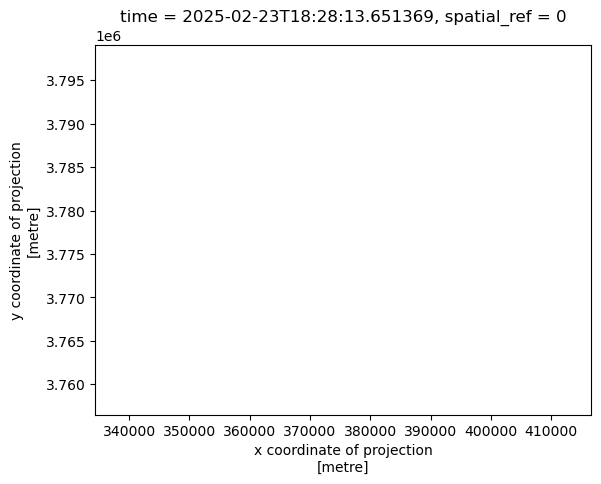

In [19]:
# Plot the true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow()
plt.show()

Bands with NaN values: ['green', 'blue']


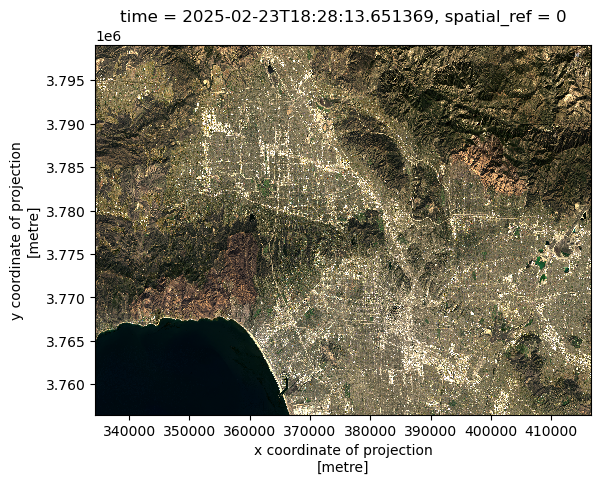

In [20]:

# Identify which bands have nan values using numpy.isnan() and utilize the robust parameter in the plot function
nan_bands = []
for band in ['red', 'green', 'blue', 'nir08', 'swir22']:
    if np.isnan(landsat[band]).any():
        nan_bands.append(band)

print("Bands with NaN values:", nan_bands)

# use .fillna() to substitude any nan values for 0
landsat = landsat.fillna(0)

# Re-plot the true color image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)
plt.show()

**Comparison of outputs:**

Part (a) produced a blank-looking image along with two warnings: one about clipping RGB data to valid ranges and another about invalid values during type conversion. This is the result of extreme outliers produced by cloud reflectance that makes all the other pixel values near zero imperceptable when matplotlib scales the image. Part (e) produces a clear, detailed true color image with no warnings. The improvement is the result of two changes: (1) using `robust=True` clips extreme outlier values for better visualization, and (2) filling NaN values with zero using `.fillna(0)` eliminates the invalid value warning. 

### 6) False color image

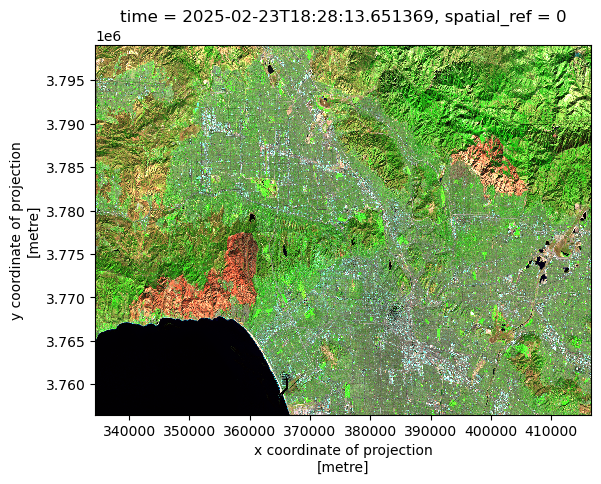

In [21]:
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)


### 7) Map

Landsat CRS: EPSG:32611
Eaton CRS: EPSG:3857
Palisades CRS: EPSG:3857


Text(337685.36156204826, 3774541.91755668, 'Palisades Fire')

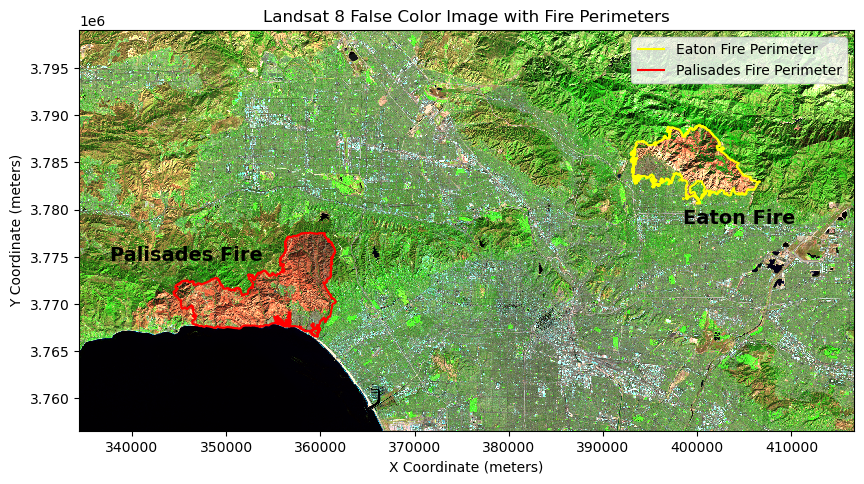

In [22]:
# Print CRS information for all datasets
print(f"Landsat CRS: {landsat.rio.crs}")
print(f"Eaton CRS: {eaton.crs}")
print(f"Palisades CRS: {palisades.crs}")

# Reproject fire perimeters to match Landsat CRS
eaton = eaton.to_crs(landsat.rio.crs)
palisades = palisades.to_crs(landsat.rio.crs)

# Create a map showing the shortwave infrared/near-infrared/red false color image together with both fire perimeters. Customize it appropriately including, at least, an informative title and legend. You may also want to include text on the map to identify which fire is which.
fig, ax = plt.subplots(figsize=(10, 10))
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax, robust=True)
eaton.boundary.plot(ax=ax, edgecolor='yellow', label='Eaton Fire Perimeter')
palisades.boundary.plot(ax=ax, edgecolor='red', label='Palisades Fire Perimeter')
plt.title('Landsat 8 False Color Image with Fire Perimeters')
plt.legend()
ax.set_ylabel('Y Coordinate (meters)')
ax.set_xlabel('X Coordinate (meters)')
ax.text(eaton.geometry.centroid.x.values[0], eaton.geometry.centroid.y.values[0] - 2700, 'Eaton Fire', color='black', fontsize=14, fontweight='bold')
ax.text(palisades.geometry.centroid.x.values[0] - 22000, palisades.geometry.centroid.y.values[0] + 8000, 'Palisades Fire', color='black', fontsize=14, fontweight='bold')


**Figure Description:**

This map displays a false color composite image of the Eaton and Palisades fire areas captured by Landsat 8. The image uses shortwave infrared (SWIR), near-infrared (NIR), and red bands to highlight burn scars and vegetation health. Healthy vegetation appears bright green due to high NIR reflectance, while burned areas appear redish brown. The fire perimeters are overlaid in yellow (Eaton Fire) and red (Palisades Fire) to highlight the extent of both fires. This false color combination is helpful for assessing fire severity and landscape recovery.